# TFSa17 ML: Deep Learning & CNN 

In [1]:
import keras

Using TensorFlow backend.


Задача этой домашки – понять, как работать с keras и вообще с нейронками.

Самая сложная часть этого задания в том, чтобы развернуть все окружение. Вам потребуется видеокарта nvidia с по крайней мере 2Гб памяти. Мануал по облакам выложу отдельно.

В качестве фреймворка нейронок будем использовать keras. Keras – это высокоуровневая надстройка над tensorflow. Документация и мануалы живут здесь: https://keras.io/

Дедлайн 31 октября в 8:00. К этому моменту нужно получить какие-то результаты на kaggle и прислать тетрадки с решениями в anytask

## Задача 1

Посчитайте, сколько параметров (весов) в этом слое:

In [2]:
input_x = keras.layers.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(filters=3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=True)(input_x)

In [5]:
x.shape

TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])

А сколько в этой модели?

In [6]:
input_x = keras.layers.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(filters=3, kernel_size=(5, 5), strides=(1, 1))(input_x)
x = keras.layers.Flatten()(x)
output_x = keras.layers.Dense(10)(x)

model = keras.models.Model(inputs=input_x, outputs=output_x)

Можно просто вызвать `model.summary()`, чтобы посмотреть правильный ответ. Мне же нужно от вас развернутое объяснение, почему ответ именно такой



In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 3)       228       
_________________________________________________________________
flatten_1 (Flatten)          (None, 145200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1452010   
Total params: 1,452,238
Trainable params: 1,452,238
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Ваш развернутый ответ

# Задача 2

Предлагаю порешать вот это соревнование: https://www.kaggle.com/c/dog-breed-identification.
Будем определять породу собак по фото.

От вас требуется получить более-менее достойное качество, например находиться в первой половине лидерборда. Пожалуйста, в названии команды указывайте <span style='color: red'>(TFS)</span> (это вот тут https://www.kaggle.com/c/dog-breed-identification/team). У вас должен быть ноутбук, где будет:
* решение, сделанное руками
* решение, где вы дообучаете предобученную на imagenet модель (https://keras.io/applications/)

Не важно, какое решение из двух лучше, главное -- это лидерборд и наличие двух моделей в ноутбуке

Ниже приведу пример базового решения для MNIST (нет, MNIST зарешивать не будем):

## MNIST

Вот пример базового варианта сетки, которая будет классифицировать MNIST

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

(60000, 28, 28)


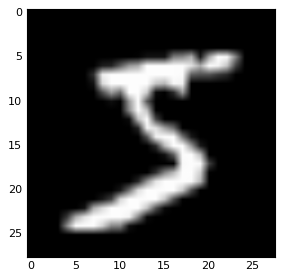

In [9]:
# скачиваем данные
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape) # размер train датасета -- 60к черно-белых картинок размером 28x28
plt.imshow(x_train[0], cmap='gray') # посмотрим на одну из картинок

In [10]:
batch_size = 128 # это количество картинок, по которым происходит один проход по нейронке, а потом -- один шаг в сторону антиградиента 
num_classes = 10 # количество классов == количество цифр
epochs = 12 # эпоха -- это один обход всего датасета. здесь для обучения мы прогоняем всю выборку 5 раз 
img_rows, img_cols = 28, 28 # размер картинок

In [11]:
# есть два подхода к порядку размерностей тензора:
# как у theano (channels_first): [objects, channels, rows, cols]
# как у tensorflow (channels_last): [objects, rows, cols, channels]
# этот порядок задается в keras.json (https://keras.io/backend/#kerasjson-details)
# по дефолту все стоит для tensorflow и скорее всего ничего менять не надо

# в датасете MNIST размерность 3 (objects, rows, cols), так как у черно-белых картинок один канал.
# Нужно привести матрицы к виду [objects, rows, cols, channels]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# картинки обычно 24битные, по 8 бит на канал, то есть для каждого канала цвет имеет интенсивность от 0 до 255.
# приведем интенсивности пикселей в [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# мы хотим получить на выходе нейронки, к какому из 10 классов относится текущая картинка.
# Нейроны без нелинейности выдают непрерывные значения. Можно было бы, например, сделать на выход один нейрон 
# и пытаться оптимизировать его через MSE. Например, если на каритнке 3, то нейрон выдает значение в районе [2.5, 3.5).
# Сразу понятно, что такой подход не слишком естественен (допустим, у нас есть датасет, в котором 1 и 7 не различимы,
# получается, что оптимально всегда выдавать для них 4)
# Вместо этого сделаем на последнем слое 10 нейронов, по одному на класс, и будем предсказывать вероятности того,
# что на картинке определенная цифра.

# Для того, чтобы обучать сеть с 10 нейронами в последнем слое, нам нужно, чтобы вектор ответов тоже имел длину 10
# Нам нужно вот такое преобразование: 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
old_y_train, old_y_test = y_train, y_test
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [12]:
old_y_train[0], '->', y_train[0]

(5, '->', array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))

In [13]:
# подготовили данные, теперь делаем саму нейронку.
# создаем объект Sequential, который означает самую простую архитетуру, где слои следуют друг за другом
# Делаем обычную архитектуру, где сверточные слои перемежаются с max pooling, потом делаем тензор плоским,
# добавляем полносвязный слой, дропаут и в конце полносвязный слой с количеством нейронов, равным количеству классов.
# В конце добавляем SoftMax, чтобы получить вероятности

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Если бы у нас было два класса, можно было бы использовать два нейрона и категориальную кросс-энтропию, 
# или один нейрон и бинарную кроссэнтропию. Но здесь вариантов нет, так что категориальная кроссэнтропия

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
# Здесь можно было бы заняться расширением выборки (это еще называется аугментация данных).
# О том, как это делать в keras, можно почитать вот здесь: https://keras.io/preprocessing/image/
# Поле применения аугментации здесь довольно ограничено, т.к. мы не можем поворачивать картинки на большой угол и отражать.
# Разные небольшие преобразования к мелкой картинке могут привести к ее размытию настолько, что она не будет похожа на цифру
# В общем, здесь аугментации просто не будет, но для больших картинок она крайне полезна

hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
36096/60000 [=================>............] - ETA: 89s - loss: 0.3373 - acc: 0.8964

KeyboardInterrupt: 

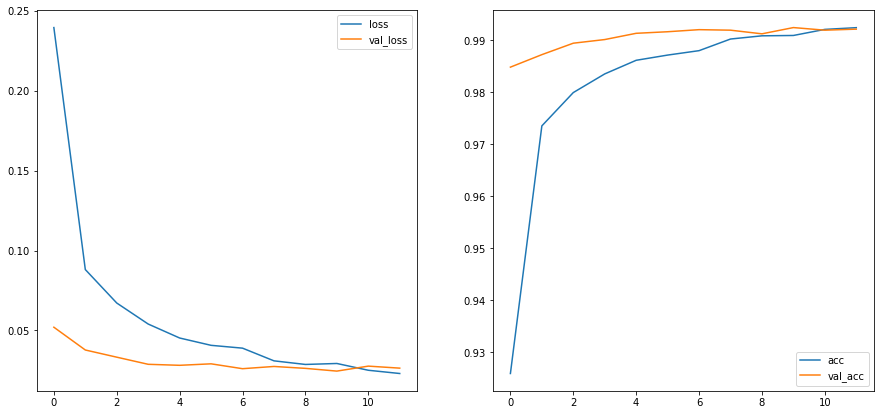

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].legend()
ax[1].plot(hist.history['acc'], label='acc')
ax[1].plot(hist.history['val_acc'], label='val_acc')
ax[1].legend()

## Рекомендации
* Участники соревнования часто выкладывают готовые варианты решения (https://www.kaggle.com/c/dog-breed-identification/kernels)
* Когда делаете свою архитектуру, ищите вдохновение у готовых архитектур, например у VGG16 (https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py)
* Используйте аугментации, они увеличивают обучающую выборку и делают решение более устойчивым: https://keras.io/preprocessing/image/. Основной критерий, что можно применять, а что нет, такой: если визуально кажется, что измененная картинка могла бы существовать в тесте, то все ок. Отражать по горизонтали картинки с собаками  -- правильно, отражать по горизонтали цифры -- неправильно.
* Callbacks https://keras.io/callbacks/: 
  * Используйте ModelCheckpoint для того, чтобы автоматически сохранять наилучшие модели
  * В kaggle-like задачах часто идет борьба за 3-4 знак после запятой. ReduceLROnPlateau позволяет уменьшать learning rate тогда, когда обучение с текущим lr останавливается